In [1]:
import math

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import warnings

In [2]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
df = pd.read_csv('dataset/salesdaily.csv', parse_dates=['datum'])
df.set_index('datum', inplace=True)
df.index.rename('DateTime', inplace=True)

In [4]:
df.drop(columns=['M01AB', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06'], inplace=True)

In [5]:
df.head()

,M01AE,Year,Month,Hour,Weekday Name
DateTime,,,,,
2014-01-02,3.67,2014,1,248,Thursday
2014-01-03,4.00,2014,1,276,Friday
2014-01-04,1.00,2014,1,276,Saturday
2014-01-05,3.00,2014,1,276,Sunday
2014-01-06,1.00,2014,1,276,Monday


In [6]:
def adf_test(timeseries):
    test_stat = adfuller(timeseries)
    result = pd.Series({'ADF statistic': test_stat[0],
                       'p-value': test_stat[1],
                        'Used lags': test_stat[2],
                        'Observations used': test_stat[3]})
    for key, value in test_stat[4].items():
        result['Critical value ({})'.format(key)] = value
    if test_stat[1] < 0.05:
        print("Reject null hypothesis! Indicates that the data is stationary.")
    else:
        print("Accept null hypothesis! Indicates that the data is not stationary.")
    return result

def kpss_test(timeseries):
    test_stat = kpss(timeseries)
    result = pd.Series({'KPSS statistic': test_stat[0],
                       'p-value': test_stat[1],
                        'Used lags': test_stat[2]})
    for key, value in test_stat[3].items():
        result['Critical value ({})'.format(key)] = value
    if test_stat[1] < 0.05:
        print("\nReject null hypothesis! Indicates that the data is not stationary.")
    else:
        print("\nAccept null hypothesis! Indicates that the data is stationary.")
    return result

In [7]:
adf_test(df['M01AE'])

Reject null hypothesis! Indicates that the data is stationary.


ADF statistic          -7.472604e+00
p-value                 5.008856e-11
Used lags               2.100000e+01
Observations used       2.084000e+03
Critical value (1%)    -3.433492e+00
Critical value (5%)    -2.862928e+00
Critical value (10%)   -2.567509e+00
dtype: float64

In [8]:
warnings.filterwarnings("ignore")

kpss_test(df['M01AE'])


Accept null hypothesis! Indicates that the data is stationary.


KPSS statistic            0.333548
p-value                   0.100000
Used lags                17.000000
Critical value (10%)      0.347000
Critical value (5%)       0.463000
Critical value (2.5%)     0.574000
Critical value (1%)       0.739000
dtype: float64

**Both test is showing the series as stationary.**

In [9]:
decomposition_result = seasonal_decompose(df['M01AE'])

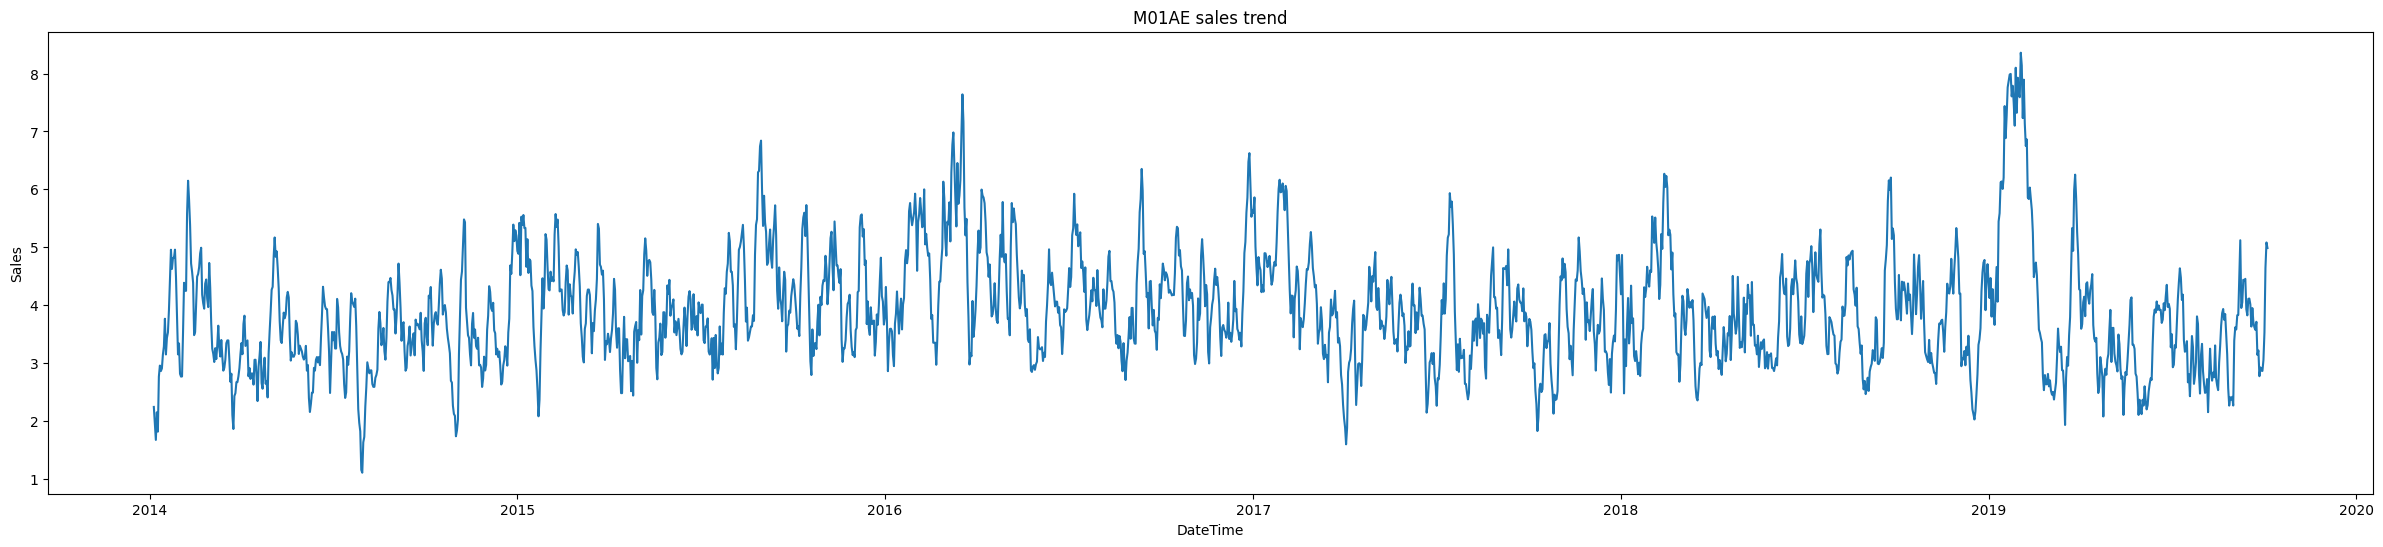

In [10]:
# Set the plot size (width, height) in inches
fig, ax = plt.subplots(figsize=(30, 6))

# Plot the trend component
ax.plot(decomposition_result.trend)

# Set the labels and title
ax.set_xlabel('DateTime')
ax.set_ylabel('Sales')
ax.set_title('M01AE sales trend')

# Show the plot
plt.show()

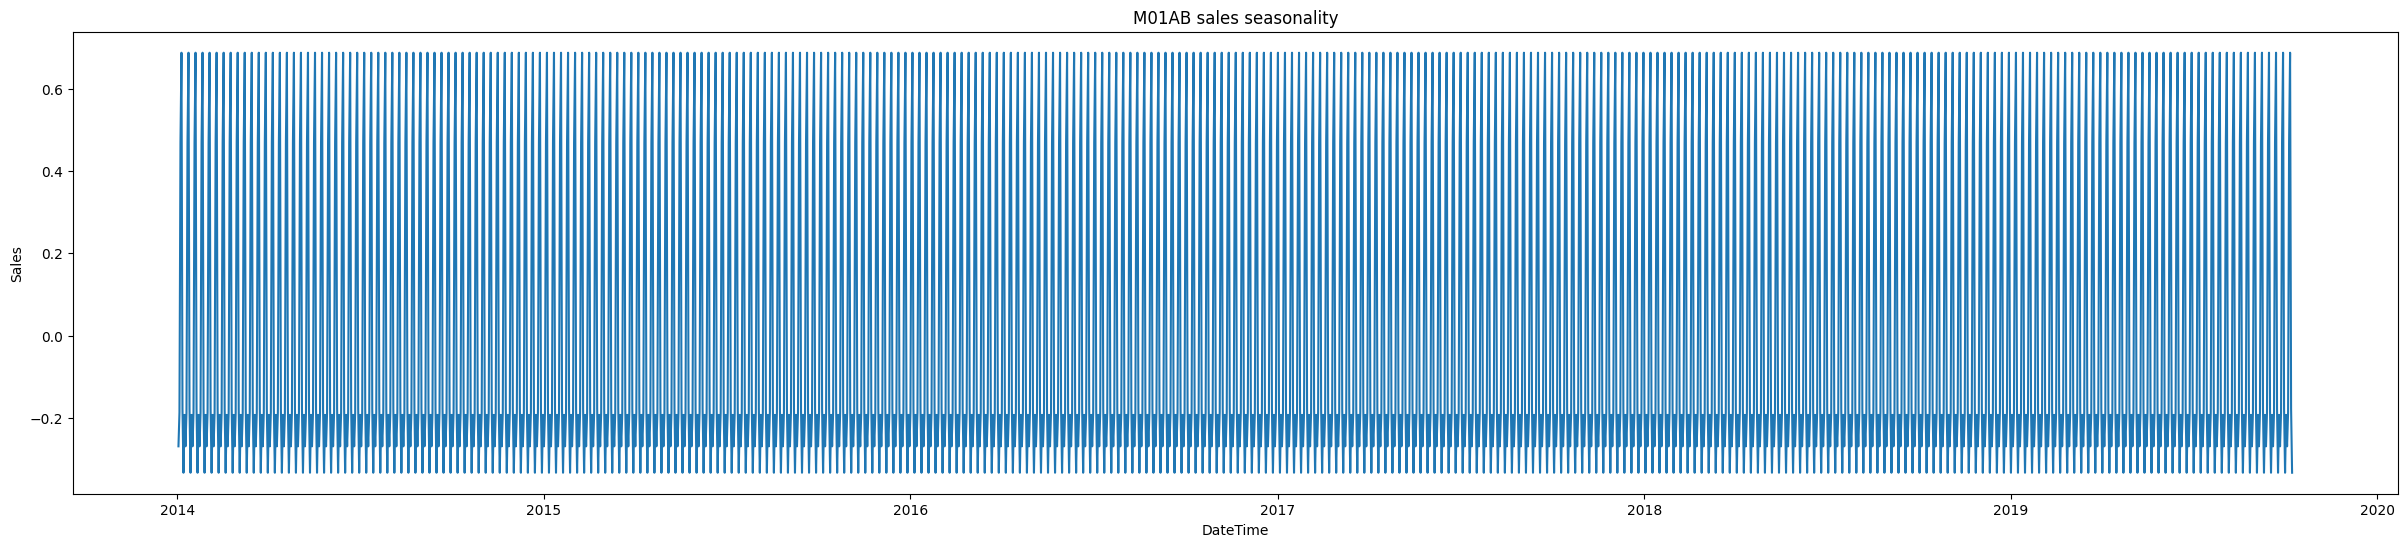

In [11]:
# Set the plot size (width, height) in inches
fig, ax = plt.subplots(figsize=(30, 6))

# Plot the trend component
ax.plot(decomposition_result.seasonal)

# Set the labels and title
ax.set_xlabel('DateTime')
ax.set_ylabel('Sales')
ax.set_title('M01AB sales seasonality')

# Show the plot
plt.show()

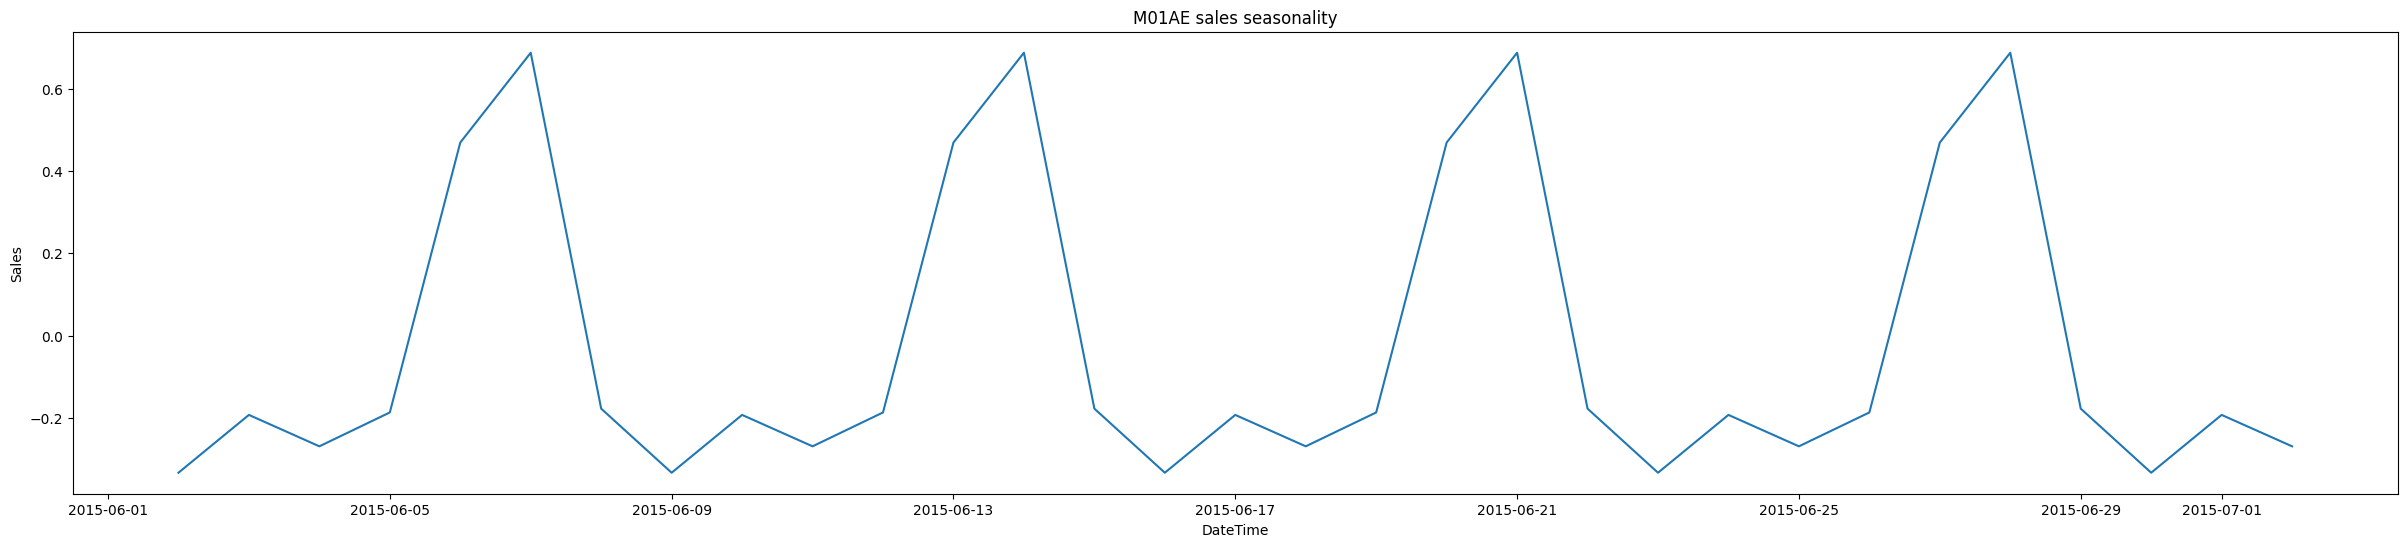

In [12]:
# Set the plot size (width, height) in inches
fig, ax = plt.subplots(figsize=(30, 6))

# Plot the trend component
ax.plot(decomposition_result.seasonal['2015-06-02': '2015-07-02'])

# Set the labels and title
ax.set_xlabel('DateTime')
ax.set_ylabel('Sales')
ax.set_title('M01AE sales seasonality')

# Show the plot
plt.show()

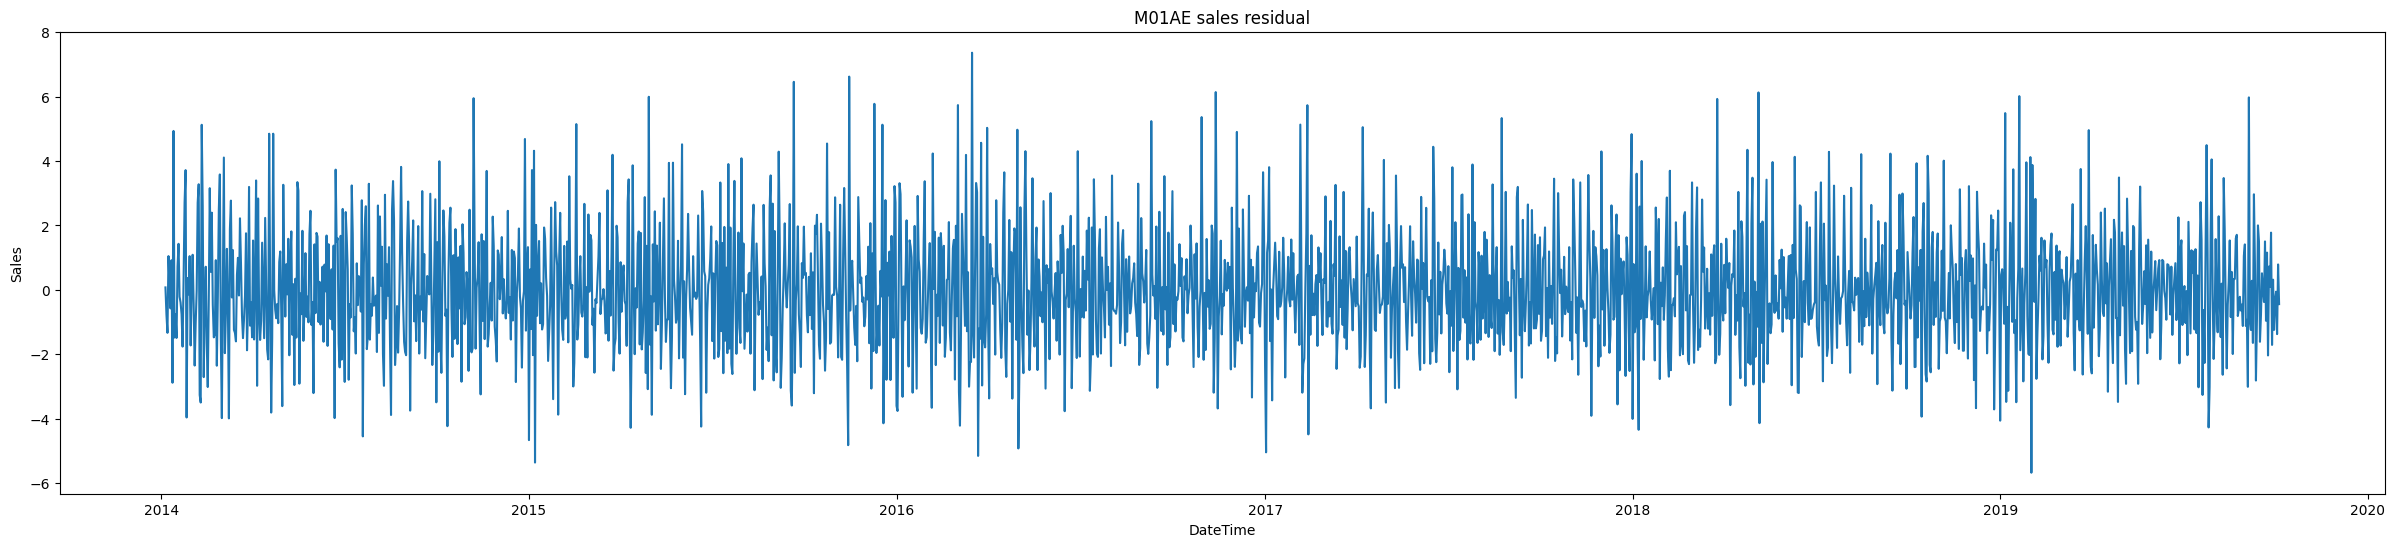

In [13]:
# Set the plot size (width, height) in inches
fig, ax = plt.subplots(figsize=(30, 6))

# Plot the trend component
ax.plot(decomposition_result.resid)

# Set the labels and title
ax.set_xlabel('DateTime')
ax.set_ylabel('Sales')
ax.set_title('M01AE sales residual')

# Show the plot
plt.show()

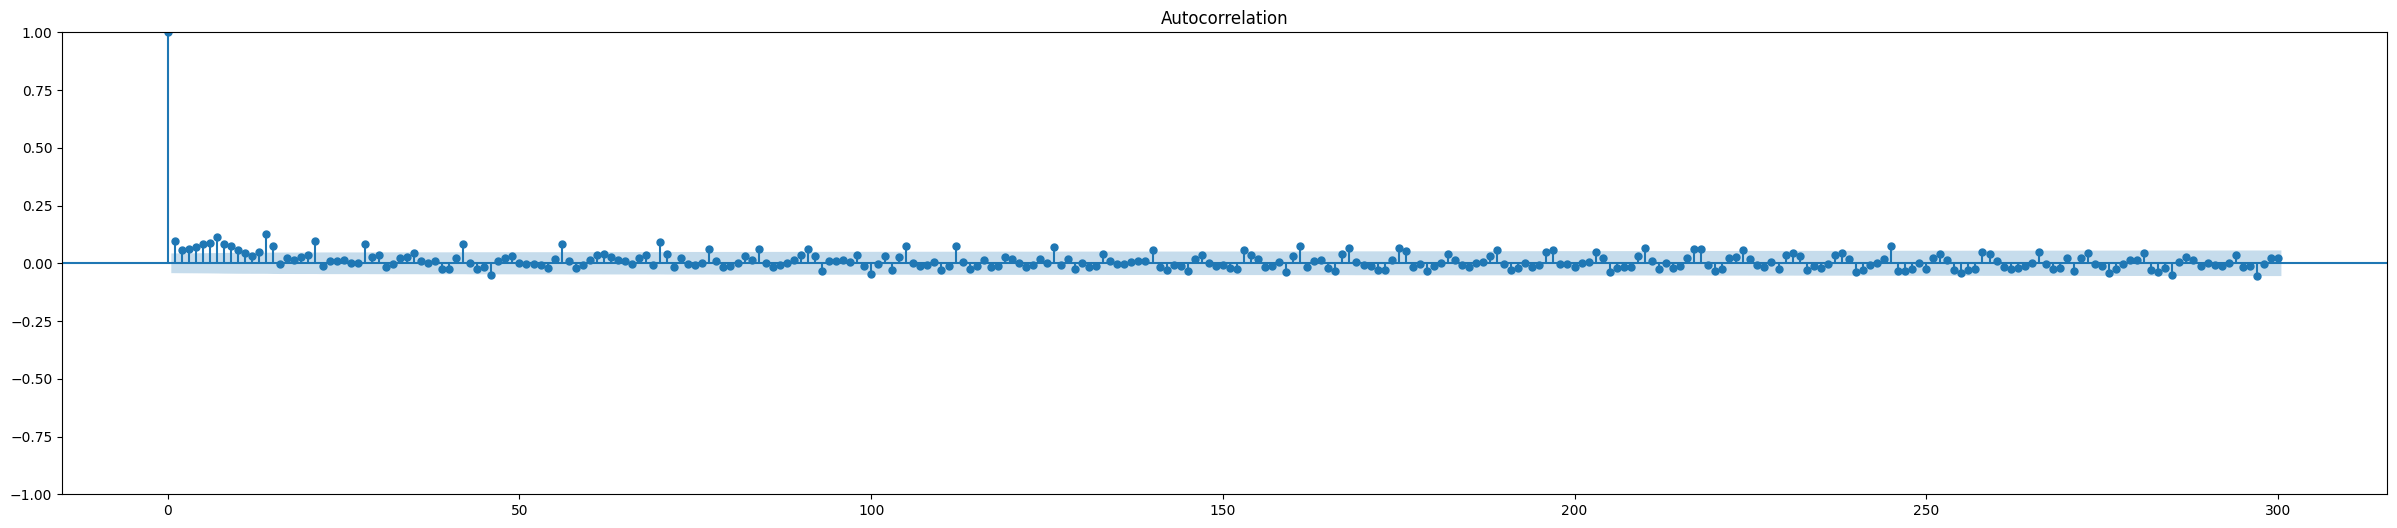

In [14]:
fig, ax = plt.subplots(figsize=(30, 6))
plot_acf(df['M01AE'], lags=300, ax=ax);

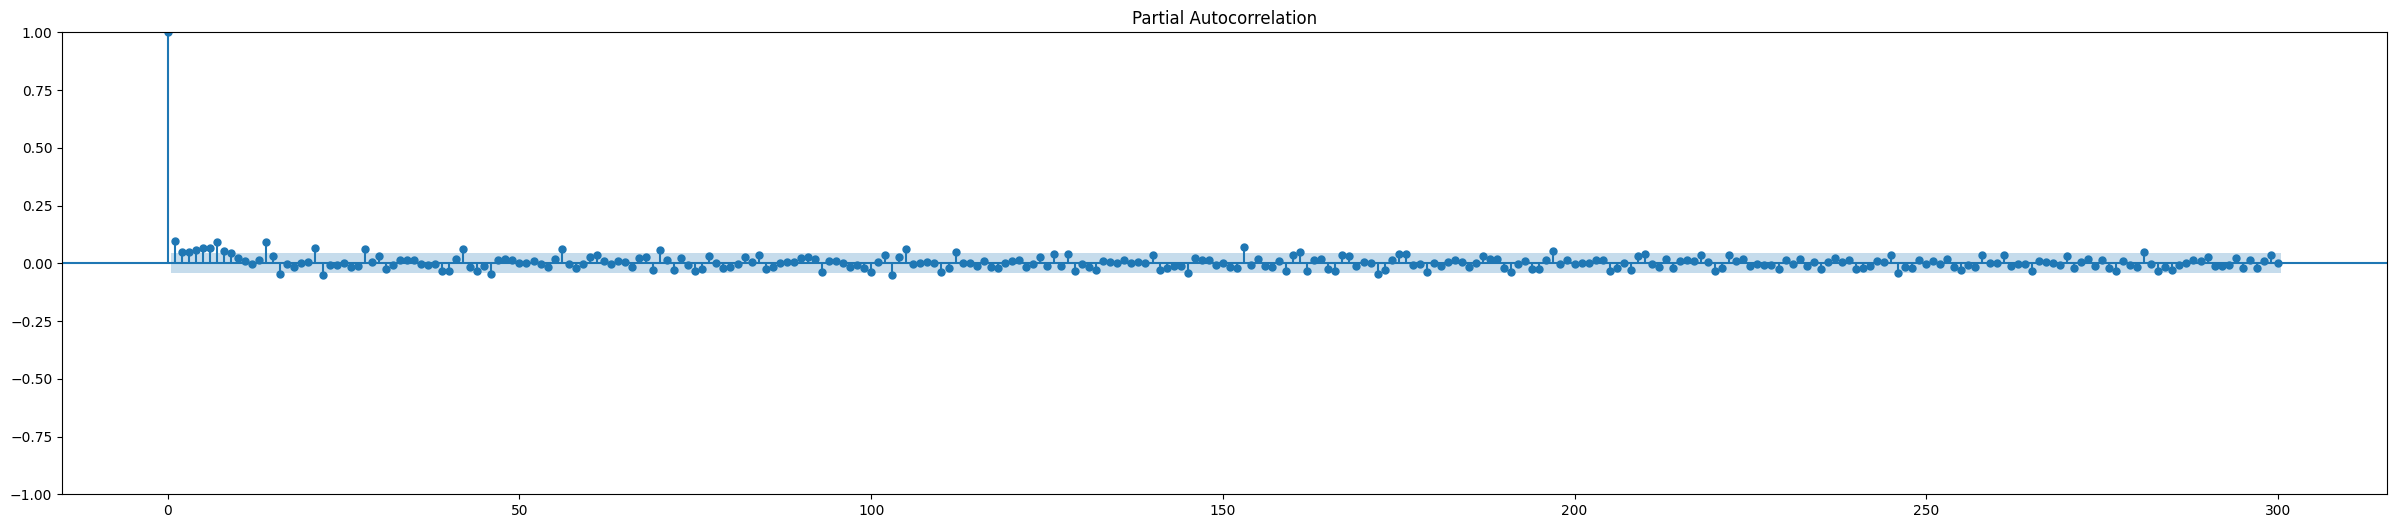

In [15]:
fig, ax = plt.subplots(figsize=(30, 6))
plot_pacf(df['M01AE'], lags=300, ax=ax);

In [16]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


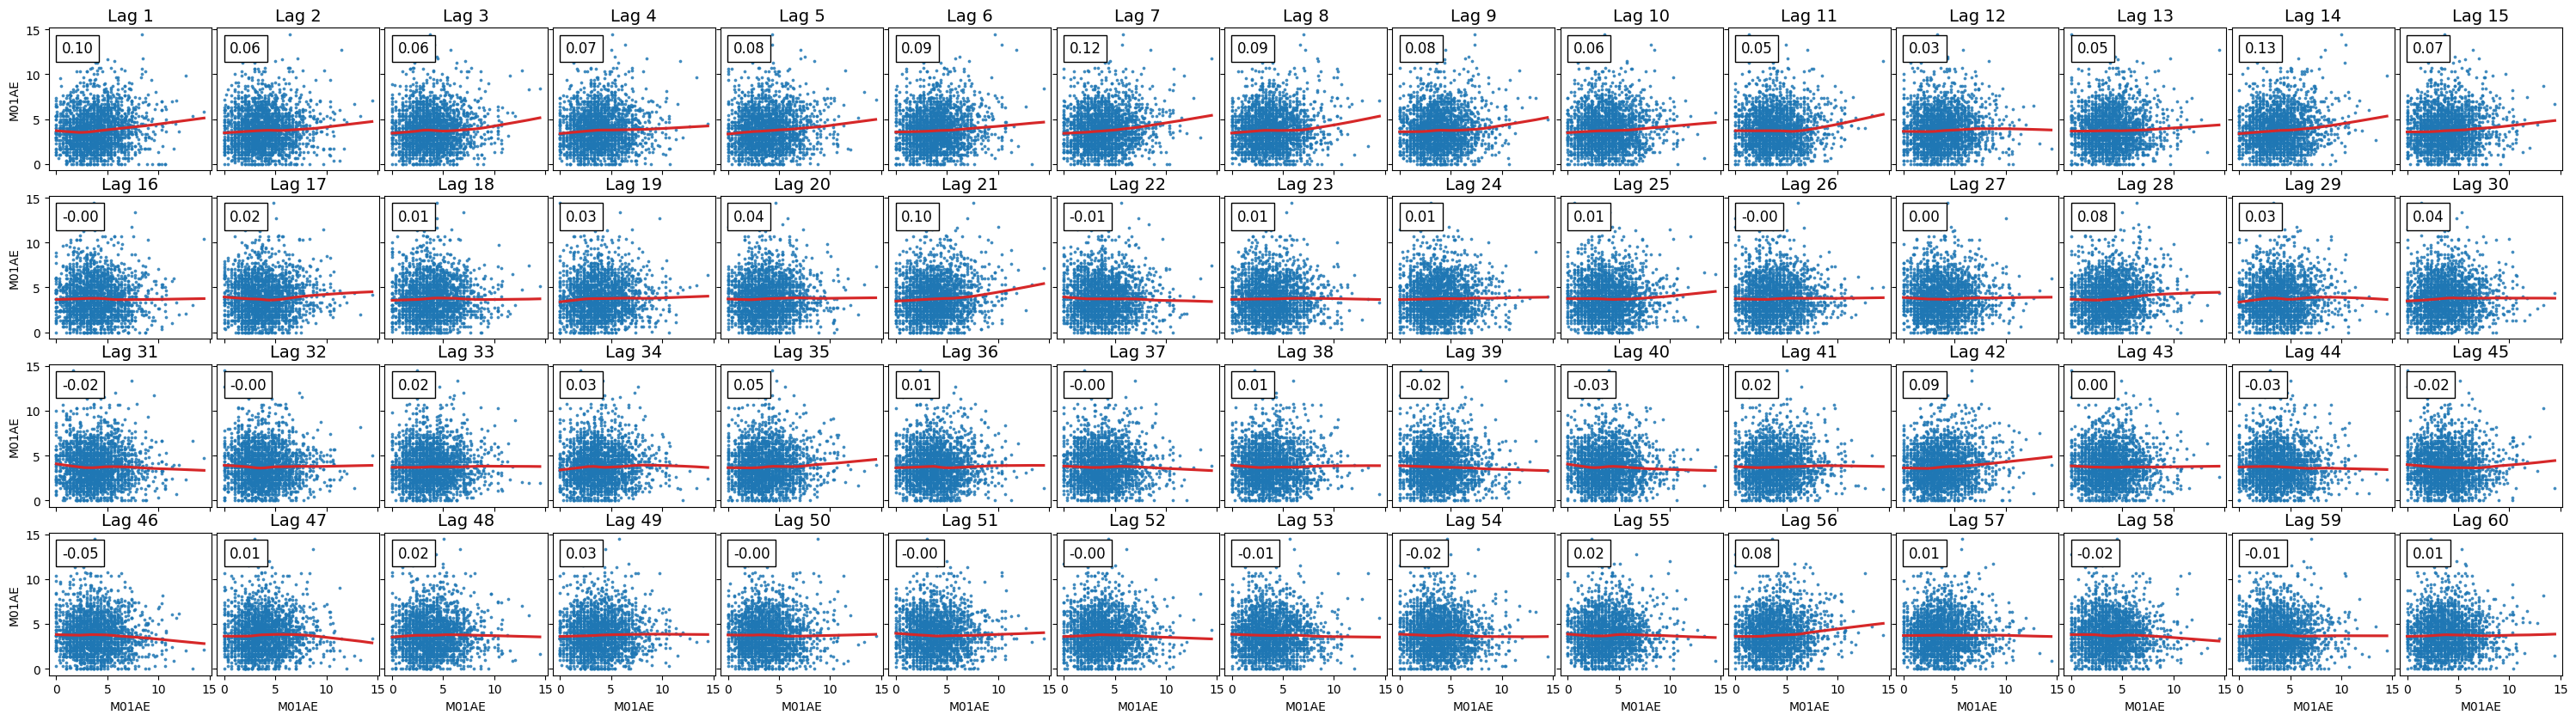

In [17]:
_ = plot_lags(df['M01AE'], lags=60, nrows=4)

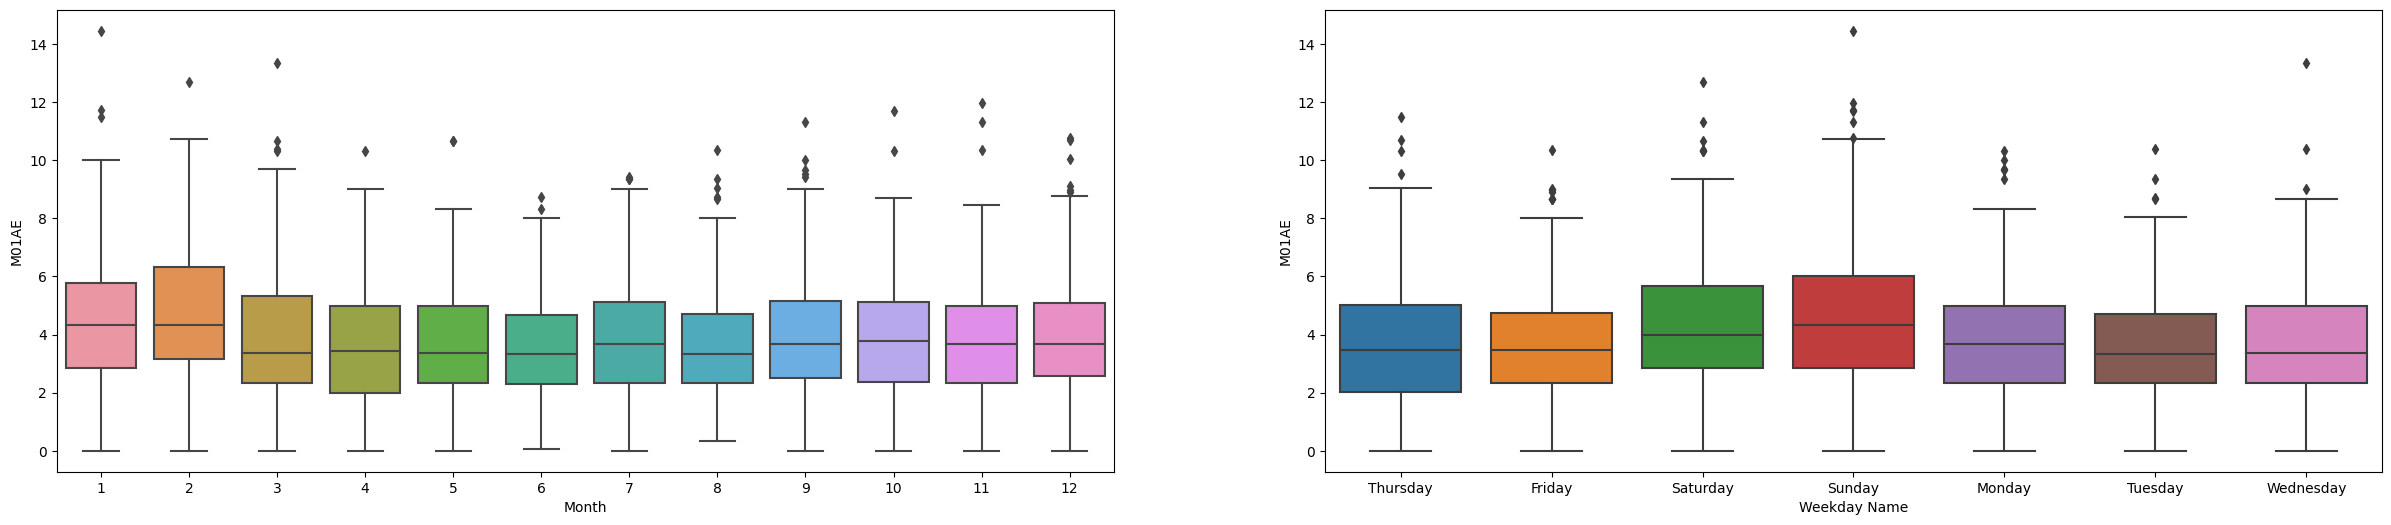

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(30, 6))

sns.boxplot(data=df, x="Month", y='M01AE', ax=ax1)
sns.boxplot(data=df, x="Weekday Name", y='M01AE', ax=ax2);

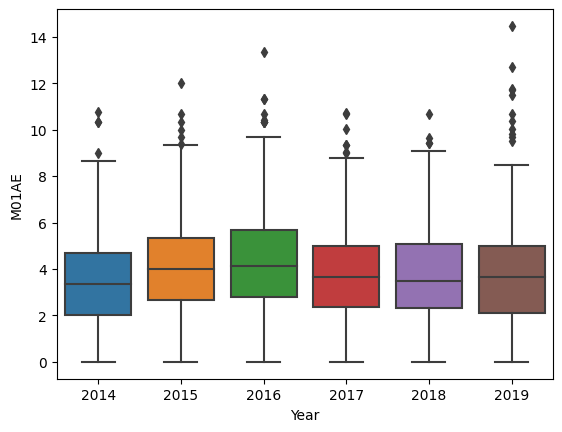

In [20]:
sns.boxplot(data=df, x="Year", y='M01AE');

### Baseline Model

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

In [ ]:
# train_test_split
train, test = df['1st order differencing'].iloc[:1837], df['1st order differencing'].iloc[1837:]

In [ ]:
train.shape, test.shape

((1837,), (268,))

In [ ]:
train

DateTime
2014-01-03    8.00
2014-01-04   -6.00
2014-01-05    2.00
2014-01-06    1.00
2014-01-07   -5.00
              ... 
2019-01-09   -1.34
2019-01-10    5.00
2019-01-11   -2.67
2019-01-12    1.33
2019-01-13    1.67
Name: 1st order differencing, Length: 1837, dtype: float64

In [ ]:
# train MA model
ma = ARIMA(train, order=(0, 0, 1)).fit()
print(ma.params)


const     0.000509
ma.L1    -0.984435
sigma2    7.075326
dtype: float64


In [ ]:
predictions = ma.predict(start=test.index[0], end=test.index[-1], dynamic=False)

In [ ]:
def mean_absolute_percentage_error(actual, predicted):
  mape = np.sum(np.abs((actual-predicted)/actual)) * 1/len(actual) * 100
  return mape 

In [ ]:
def over_under_forecast(actual, predicted):
    over_forecast = 0
    under_forecast = 0
    exact_forecast = 0
    for i in range(len(actual)):
        if actual[i] > predicted[i]:
            under_forecast+=1
        elif actual[i] < predicted[i]:
            over_forecast += 1
        else:
              exact_forecast+=1
    return (over_forecast, under_forecast, exact_forecast)

In [ ]:
# model evaluation on test set
mae = mean_absolute_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions)
over_forecast, under_forecast, exact_forecast = over_under_forecast(test, predictions)
print('Test MAE: %.3f' %mae)
print('Test mean absolute percentage error MAPE: %.3f%%' %mape)

print('Over forecast: {}, Under forecast: {}, Exact forecast: {}'.format(over_forecast, under_forecast, exact_forecast))

Test MAE: 3.272
Test mean absolute percentage error MAPE: inf%
Over forecast: 137, Under forecast: 131, Exact forecast: 0


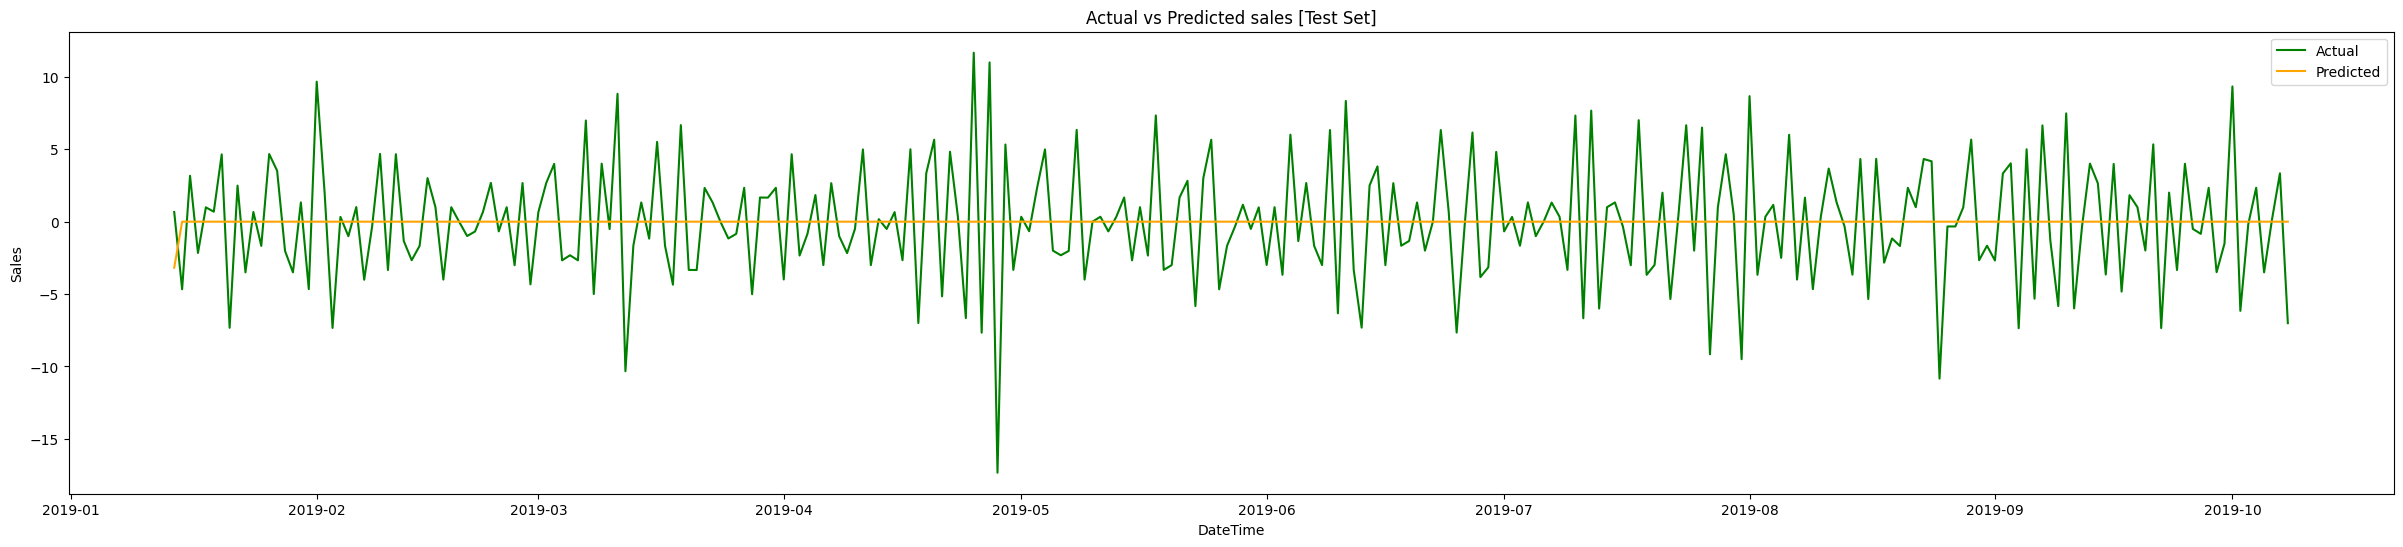

In [ ]:
plt.figure(figsize=(30,6))
plt.plot(df.index[len(train):], test, color='green')
plt.plot(df.index[len(train):], predictions, color='orange')
plt.ylabel('Sales')
plt.xlabel('DateTime')
plt.title('Actual vs Predicted sales [Test Set]')
plt.legend(['Actual', 'Predicted'])
plt.show()


In [ ]:
train_predictions = ma.predict(start=train.index[0], end=train.index[-1], dynamic=False)

In [ ]:
1/len(train) * 100

0.05443658138268917

In [ ]:
np.sum(np.abs((train-train_predictions)/train)) 

inf

In [ ]:
# model evaluation on test set
mae = mean_absolute_error(train, train_predictions)
mape = mean_absolute_percentage_error(train, train_predictions)
over_forecast, under_forecast, exact_forecast = over_under_forecast(train, train_predictions)
print('Test MAE: %.3f' %mae)
print('Test mean absolute percentage error MAPE: %.3f%%' %mape)

print('Over forecast: {}, Under forecast: {}, Exact forecast: {}'.format(over_forecast, under_forecast, exact_forecast))

Test MAE: 2.100
Test mean absolute percentage error MAPE: inf%
Over forecast: 971, Under forecast: 866, Exact forecast: 0


In [ ]:
df.index[len(test):].shape

(1837,)

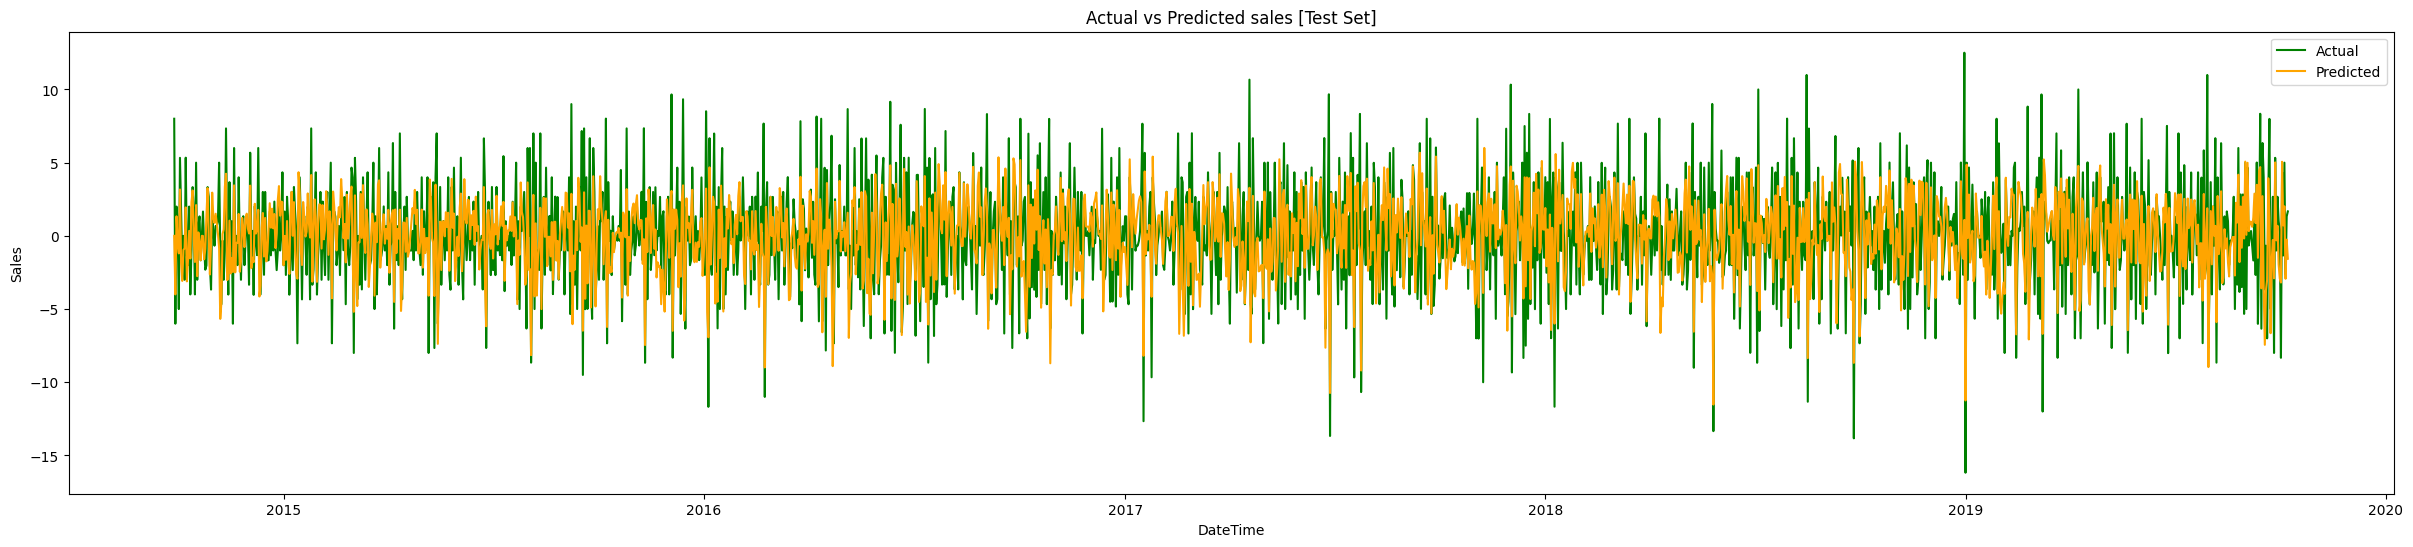

In [ ]:
plt.figure(figsize=(30,6))
plt.plot(df.index[len(test):], train, color='green')
plt.plot(df.index[len(test):], train_predictions, color='orange')
plt.ylabel('Sales')
plt.xlabel('DateTime')
plt.title('Actual vs Predicted sales [Test Set]')
plt.legend(['Actual', 'Predicted'])
plt.show()
